In [1]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

Задание 1:Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1015.4531113448329
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4050.500202986567


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

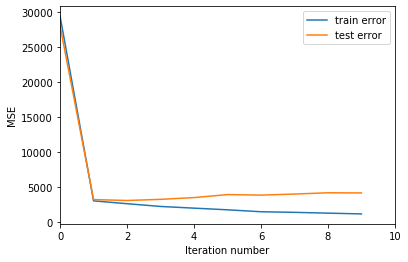

In [13]:
get_error_plot(n_trees, train_errors, test_errors)

In [14]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 10
eta = 0.1
train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

In [15]:
def depth_error_plot(max_depth, train_err, test_err):
    plt.xlabel('tree_depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.legend(loc='upper right')
    plt.show()

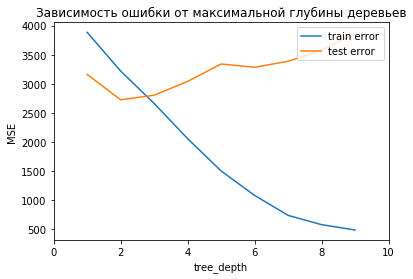

In [16]:
depth_error_plot(max_depth, train_errors_arr, test_errors_arr)

1.  При увеличении количества деревьев ошибка на тренировочных данных уменьшается.
2.  Ошибка на тренировочной выборке уменьшается при увеличении глубины дерева, но на тестовой выборке начинает расти.

Задание 2: (опция). Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [17]:
def sgb_fit(subsample_value, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        
        # генерируем случайную подвыборку для стохастического градиентного бустинга размером 0.5
        qtt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qtt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [18]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

In [19]:
trees, train_errors, test_errors = sgb_fit(0.5, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 5175.398135633614
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6988.265691111284


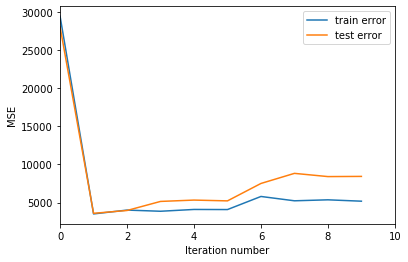

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

Задание 3: (опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [37]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [38]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {} # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [39]:
def gini(labels):
    # подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] = 1
        
    # расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    
    return impurity

In [40]:
def quality(left_labels, right_labels, current_gini):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [41]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [42]:
def find_best_split(data, labels, n_features, min_leaf):
    # реализована возможность выбора количества признаков и минимального количества объектов в узле
    
    current_gini = gini(labels)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
        
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            # выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
    return best_quality, best_t, best_index

In [43]:
def build_tree(data, labels, n_features, min_leaf, depth=1, max_depth=9):

    quality, t, index = find_best_split(data, labels, n_features, min_leaf)
    
    #  базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth == max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, min_leaf, depth+1, max_depth)
    false_branch = build_tree(false_data, false_labels, n_features, min_leaf, depth+1, max_depth)

    # возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [44]:
def classify_object(obj, node):

    #  останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [45]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [46]:
def gb_tree_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, n_features, min_leaf):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = build_tree(X_train, y_train, n_features, min_leaf, depth=1, max_depth=3)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            #tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, predict(X_train, tree)))
            test_errors.append(mean_squared_error(y_test, predict(X_test, tree)))
        
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [47]:
# Число деревьев в ансамбле
n_trees = 1

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

n_features = X.shape[0]

min_leaf = 1

trees, train_errors, test_errors = gb_tree_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, n_features, min_leaf)

In [49]:
train_errors

[11630.06344410876]

In [50]:
test_errors

[11315.342342342343]

Вывод: по сравнению со стандартным градиентным бустингом, где применяется ансамбль деревьев, в реализации с одним деревом решений ошибка намного выше. Это объясняется тем, что в градиентном бустинге деревья строятся одно за другим, тем самым уменьшая ошибку ансамбля.